# Introduction to *HyperSpy* and *LumiSpy*

Tutorial for the **Workshop on Cathodoluminescence and Electron Beam Induced Current of Semiconductor Nanostructures**

Grenoble, March 24, 2023

**Table of Contents:**

- [Import packages](#Import-packages)
- [Loading files](#Loading-files)
- [Data structure / Axes handling](#Data-structure-/-Axes-handling)
- [Metadata](#Metadata)
- [Plot / Explore](#Plot-/-Explore)
- [Indexing](#Indexing)
- [Axes types / Convert to energy scale](#Axes-types-/-Convert-to-energy-scale)
- [Model fitting](#Model-fitting)
- [Correction of spectral defects](#Correction-of-spectral-defects)
- [Peak identification / Centroid / Peak width](#Peak-identification-/-Centroid-/-Peak-width)
- [Advanced fitting example](#Advanced-fitting-example)

## Import packages

We import the public functions (api = application programming interface) of `HyperSpy`. Some functionalities of `LumiSpy` are directly available if the package is installed, but we can separately load it to access extra utilities. Finally, `matplotlib.pyplot` provides some additional plotting functions we will use:

In [1]:
%matplotlib widget
# Use '%matplotlib widget' in JupterLab and '%matplotlib notebook' in JupyterNotebook for interactive inline functionality (e.g. on binder)
# For pop-up window plots on your local computer, use '%matplotlib tk' or '%matplotlib qt' instead
import hyperspy.api as hs
import lumispy as lum
import matplotlib.pyplot as plt
import numpy as np

## Loading files

For saving analyses, HyperSpy has its own hdf5-based data format `.hspy`.

HyperSpy supports a wide range of microscopy (and spectroscopy) related **data file types**:

- Gatan `.dm3/.dm4`
- Attolight `.sur`
- Delmic `.hdf5` (might still need a parsing script at the moment)
- Hamamatsu streak camera images in `.tif` format
- ...

Further spectroscopy-related formats will be available soon (through **RosettaSciIO**):

- Horiba JobinYvon XML `.xml`
- TriVista XML `.tvf`
- Renishaw wire format `.wdf`

*You can also leave the path empty. A pop-up window will appear to select the file.*

We will load three files that we will use during the demo. A preprocessed dataset saved in the `hspy` format and two maps in the `dm4` format:

In [2]:
cl1 = hs.load("../demo-files/01/01_demo.hspy")
cl2 = hs.load("../demo-files/load_from_GatanFiles/asymmetric-peak_map.dm4")
cl3 = hs.load("../demo-files/load_from_GatanFiles/quantum-emitters_map.dm4")

To see **parameters** that the function takes, in Jupyter, you can **display the docstring** by using a `?`:

In [ ]:
hs.load?

## Data structure / Axes handling

Each HyperSpy signal object has certain attributes that contain the relevant data about the axes, data and metadata.

To understand the HyperSpy datastructure, lets have a look at the dataset `cl2` (Gatan file).

As **LumiSpy** is installed, the dataset is directly recognized as CL data and the `signal_type` set to `CLSpectrum`. (The fallback would be the more generic `Signal1D` if LumiSpy is not installed).

The **signal type** provides certain specific routines, for example conversion to energy axis in the case of luminescence data.

Our sample dataset has **two navigation dimensions** and **one signal (spectral) dimension**:

In [ ]:
cl2

The information about the axes is stored in the `axes_manager`. Thus, we can get more details about the different axes, by calling the **axes manager**:

In [ ]:
cl2.axes_manager

The **actual data** (signal intensity) is stored in a numpy array:

In [ ]:
cl2.data

## Metadata

For most supported file formats, the metadata is automatically parsed into **HyperSpy's metadata tree**.
It contains information about the measurement, but potentially also about post-processing:

In [ ]:
cl2.metadata

In a separate tree, the **complete metadata from the vendor format** is read in (which follows different conventions depending on the format):

In [ ]:
cl2.original_metadata

## Plot / Explore

We can easily plot and explore the hyperspectral data:

*(in the following, we will use the preprocessed dataset `cl1`)*

In [ ]:
cl1.plot()

Plot the **average CL spectrum** of the whole map:

In [ ]:
cl1.mean().plot()

## Indexing

HyperSpy has a powerful numpy (Matlab) style indexing mechanism that distinguishes between navigation and signal axes:

- `.inav[x1:x2,y1:y2]`
- `.isig[s1:s2]`

The index parameters can be either:
- Integer: Index in the axis array
- Float: Value in calibrated axis units

For example, we can either plot a subset of the map in navigation space (selected using pixels as index):

In [ ]:
cl1.inav[2:23,0:20].plot()

Or, we can plot the mean spectrum in a certain spectral range (selected using wavelength units):

In [ ]:
cl1.isig[440.:600.].mean().plot()

### Chromatic imaging:

Indexing can also be used for color-filtered (chromatic) imaging.

First, lets plot the **panchromatic image**:

*(the object is transposed, so that we plot the intensity over navigation instead of signal dimensions)*

In [ ]:
cl1.T.mean().plot(cmap='viridis')

Now, we can **plot the intensity in a selected a spectral window** (color-filtered image) using indexing:

In [ ]:
cl1.isig[480.:550.].T.mean().plot(cmap='viridis')

Alternatively, we can interactively select a spectral window (color-filtered image) using regions of interest:

In [ ]:
im = cl1.T
im.plot()
roi1 = hs.roi.SpanROI(left=455, right=485) #sets a digitalbandfilter
im_roi1 = roi1.interactive(im, color="red")
im_roi1_mean = hs.interactive(im_roi1.mean,
                          event=roi1.events.changed,
                          recompute_out_event=None)
im_roi1_mean.plot(cmap='viridis')

## Axes types / Convert to energy scale

Required versions: hyperspy>=1.7.0 and lumispy>=0.2

HyperSpy has different types of axes:
- The standard `UniformDataAxis` is defined through an `offset` and a `scale` (delta between pixels)
- A `FunctionalDataAxis` is defined through a `UniformDataAxis` and a `function` to convert the values
- A more general `DataAxis` is defined through an `axis` vector/array

The *wavelength* scale of our sample object is a `UniformDataAxis`:

In [ ]:
cl1.axes_manager

*LumiSpy* provides easy conversions of the signal axis to the **energy scale**:

It can either replace the axis in the existing object (default) or create a copy of the signal object with the new axis (`inplace=False`):

In [ ]:
cl1_eV = cl1.to_eV(inplace=False)

The axes manager now contains an `energy` axis, which is a non-uniform `DataAxis`:

In [ ]:
cl1_eV.axes_manager

To explore the data in the energy domain, we again plot the signal:

In [ ]:
cl1_eV.plot()

### Jacobian transformation

To preserve the integrated intensity per spectral window, a *Jacobian* transformation has to be applied to the signal intensity:

As we require $I(E)dE = I(\lambda)d\lambda$, the scale transformation $E=hc/\lambda$ implies

$$I(E) = I(\lambda)\frac{d\lambda}{dE} = I(\lambda)\frac{d}{dE}
\frac{h c}{E} = - I(\lambda) \frac{h c}{E^2}$$

(where the minus sign just reflects the different directions of integration in the wavelength and energy domains)

This transformation is the default in LumiSpy, but can be deactivated by setting `jacobian=False`.

To visualize the effect of the *Jacobian transformation*, we can plot a signal with constant intensity before and after the transformation:

In [ ]:
# Create a model signal with linear intensity
axis = {'offset': 300, 'scale': 4, 'units': 'nm', 'size': 101, 'name': 'Wavelength'}
s = hs.signals.Signal1D(np.ones(101), axes=[axis])
s.set_signal_type("Luminescence")
s2 = s.to_eV(inplace=False)

In [ ]:
# Some additional arrays to help with visualizing the spectral bins during plotting
x = np.arange(9)*50+300
x2 = lum.nm2eV(x)
y2 = hs.signals.Signal1D(np.ones(9), axes=[{'offset': 300, 'scale': 50, 'size': 9,}])
y2.set_signal_type("Luminescence")
y2.to_eV()

In [ ]:
# Plot comparative figures
fig1 = plt.figure(figsize=(10,4))
ax0 = plt.subplot(121)
plt.ylim(0,1.3)
plt.xlabel('Wavelength (nm)')
ax0.plot(s.axes_manager[0].axis,s.data,color='orange')
ax0.vlines(x,0,1,color='orange')
ax0.fill_between(s.axes_manager[0].axis,0,s.data, facecolor='orange', alpha=0.3)
ax1 = plt.subplot(122)
plt.ylim(0,0.43)
plt.xlabel('Energy (eV)')
ax1.plot(s2.axes_manager[0].axis,s2.data,color='orange')
ax1.vlines(x2,0,y2.data[::-1],color='orange')
ax1.fill_between(s2.axes_manager[0].axis,0,s2.data, facecolor='orange', alpha=0.3)

## Model fitting

We will introduce basic fitting functionality using our sample dataset `cl1`, for more details see the `Fitting_tutorial` in the [HyperSpy demos repository](https://github.com/hyperspy/hyperspy-demos).

First, we need to **initialize the model**:

In [ ]:
m = cl1_eV.create_model()

**Check the components** of the model (should be empty, but for some types of signals, an automatic background component is added):

In [ ]:
m.components

Now we need to **create some components** and **add them to the model**.

We will use a constant `Offset` and a Gaussian (defined through height and FWHM, hence `GaussianHF`):

In [ ]:
bkg = hs.model.components1D.Offset()
g1 = hs.model.components1D.GaussianHF()
m.extend([g1, bkg])
m.components

To see the parameters of our components and their default values, we can **print all parameter values**:

In [ ]:
m.print_current_values()

Lets set some **sensible starting values** for our components, for a position in the map where we know that there should be signal (as it is not the case everywhere for our sample dataset):

In [ ]:
cl1.axes_manager.indices = (7,7)
g1.centre.value = 2.4        # Gaussian centre
g1.fwhm.value = 0.1      # Gaussian width
g1.height.value = 5      # Gaussian height
bkg.offset.value = 0.1   # background offset

We can also **set boundaries** (`bmin` and `bmax`) for some of the parameters:

In [ ]:
g1.centre.bmax = g1.centre.value + 0.2
g1.centre.bmin = g1.centre.value - 0.2
g1.fwhm.bmin = 0.01

We can now **fit the model at the chosen position**, copy the result as starting value to all positions, and **plot** the result:

In [ ]:
m.fit()
m.assign_current_values_to_all()
m.plot()

Again, we can also **print the updated parameters**:

In [ ]:
m.print_current_values()

The model now has the result from our chosen pixel everywhere. Using this as optimized starting paramters, we can now **fit all pixels**. When plotting, we activate additional plotting of the individual components:

In [ ]:
m.multifit(bounded=True, show_progressbar=True)
m.plot(plot_components=True)

To plot maps of the parameters of the Gaussian, we create signal objects from these datasets:

In [ ]:
m_centre = g1.centre.as_signal()
m_centre.plot(cmap='bwr_r', centre_colormap=False) # Otherwise, it would be centred around `0` and we would see little difference between pixels
m_intensity = g1.height.as_signal()
m_intensity.plot(cmap='viridis')

### Particle segmentation

We can use the fit model as basis to do a particle segmentation by **creating a mask** for all pixels, where the intensity is below the mean value:

In [ ]:
mask_treshold = m_intensity.data.mean()
mask = m_intensity.data > mask_treshold #Returns a boolean matrix mask
plt.figure()
plt.imshow(mask)

We can now plot the previous graph of the centre-parametre, after applying the mask:

In [ ]:
(m_centre * mask).plot(cmap='bwr_r', vmin=2.3, centre_colormap=False) 

## Correction of spectral defects

Working on the unprocessed dataset `cl2`, we can introduce some basic functions for artefact correction:

### Remove background (interactive)

HyperSpy has an interactive tool for **background removal** that supports various functions, let's start by removing a **simple offset**:
1. Select a region to be used to determine the background: On the signal plot click, drag and release
2. You can still move the region or it's boundaries with the mouse and inspect the different spectra using the navigator to make sure the region is right
3. Press `Apply`

/home/jonas/.local/lib/python3.10/site-packages/jupyter_client/session.py:718: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


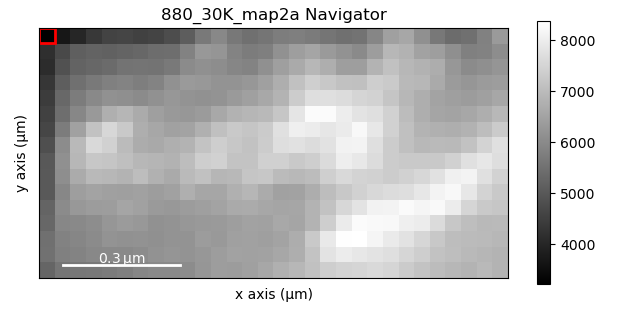

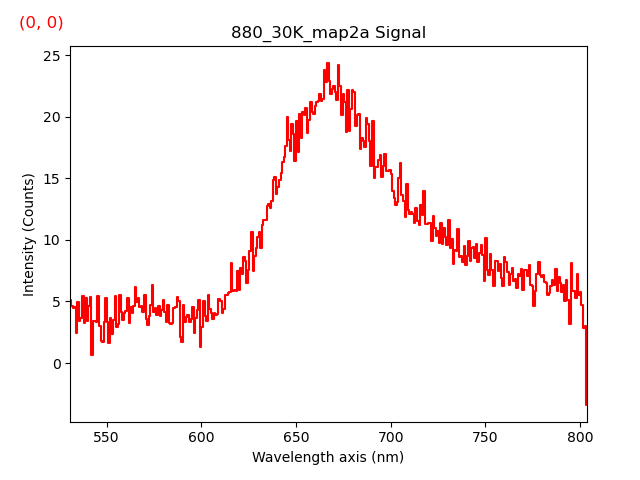

In [3]:
cl2.remove_background(background_type="Offset")

### Remove last pixels from the spectrum

The signal beyond 800 nm goes to negative values, so lets remove the last three pixels from every spectrum:

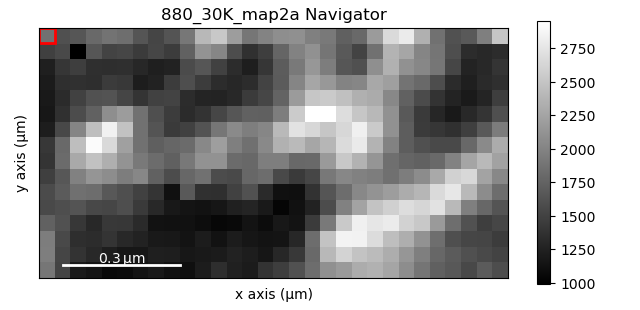

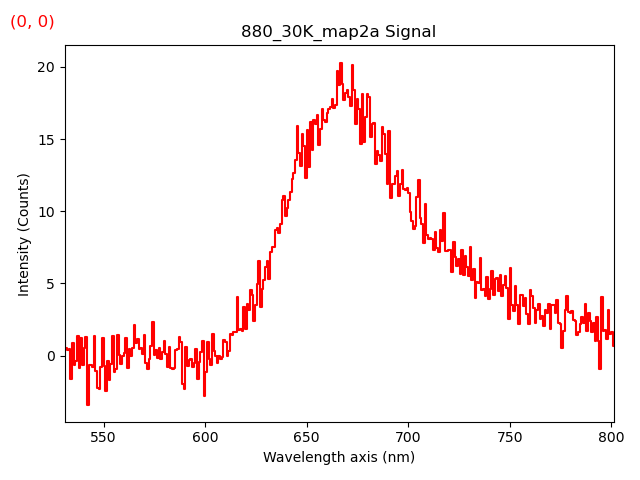

In [4]:
cl2 = cl2.isig[:-3]
cl2.plot()

### Remove spikes (interactive)

There is also a tool for interactive removal of cosmic rays (pixels with sharp spikes), see `Help` for instructions.

In brief:
- Inspect the derivate histogram
- Set a sensible threshold to catch the outliers in the histogram
- Iterate through `Find next` / `Remove spike` to continue for wrong identifications / remove identified spikes
- `Close` when finished

- *NOTE: This interactive function does not work well with inline plotting (e.g. on binder)*

In [ ]:
cl2.spikes_removal_tool()

**LumiSpy** provides an automated, non-interactive wrapper for removing spikes:

In [5]:
cl2.remove_spikes()

/home/jonas/medien/pdi/git/lumispy/lumispy/signals/cl_spectrum.py:109: UserWarning: Threshold value: 4.00
  warn(


<CLSpectrum, title: 880_30K_map2a, dimensions: (30, 16|331)>

### Data smoothing

The current dataset is quite noisy. As the peak is broad in comparison with the spectral resolution, one way to improve that is by **rebinning** the data along the signal axis:

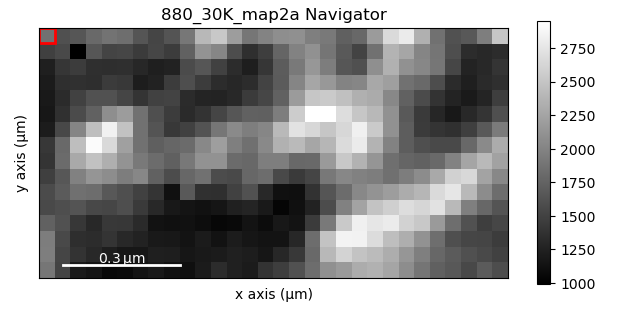

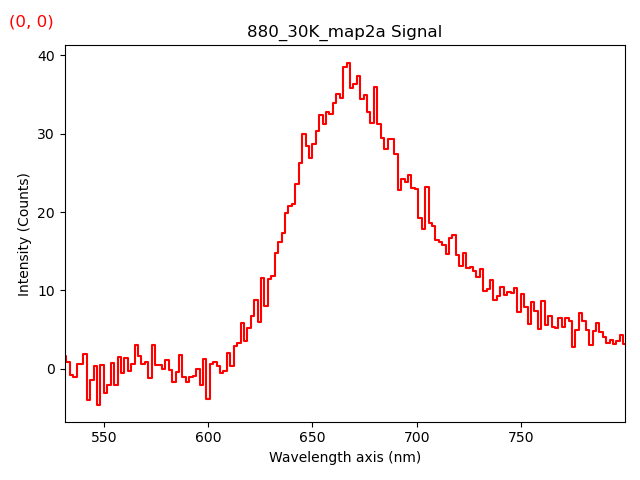

In [6]:
cl2 = cl2.rebin(scale=[1,1,2])
cl2.plot()

Additionally, HyperSpy provides three different functions for **data smoothing**:

- `smooth_lowess` (lowess smoothing)
- `smooth_savitzky_golay` (Savitzky Golay filter)
- `smooth_tv` (total variation data smoothing)

These functions can be run interactively to choose the right parameters, but the parameters can also be passed to the function:

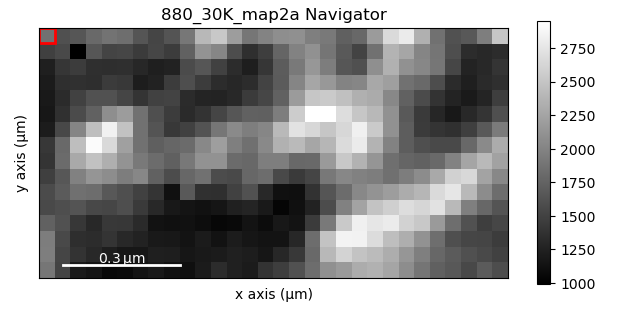

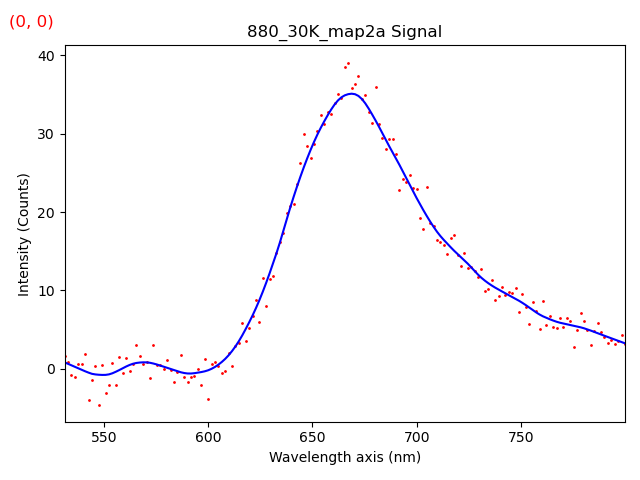

In [7]:
cl2.plot()
cl2.smooth_lowess(number_of_iterations = 2)

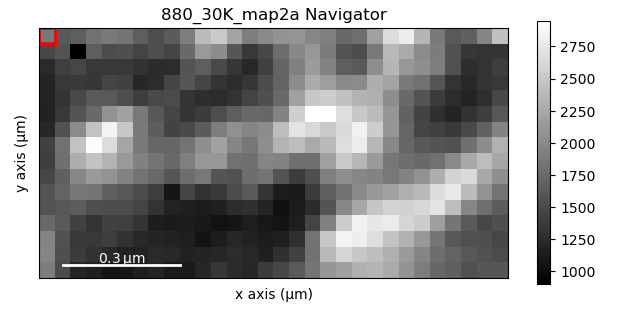

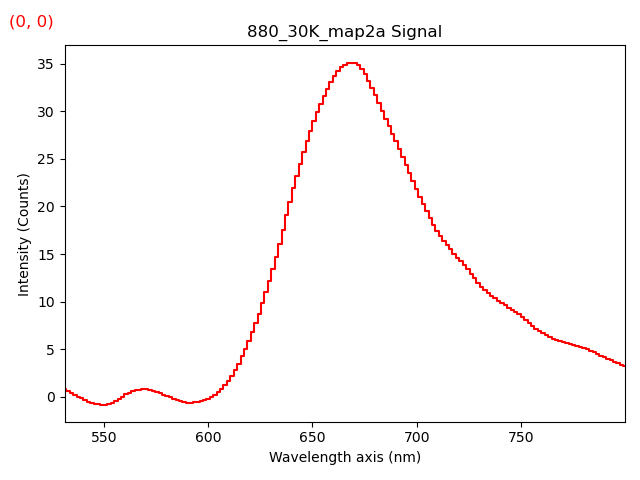

In [8]:
cl2.plot()

## Peak identification / Centroid / Peak width

In particular for asymmetric peaks, fitting might not always be the best way to determine peak characteristics. Therefore HyperSpy provides a number of additional routines.

Peaks can be identified and characterized using the **peak finder** routine `find_peaks1D_ohaver` that is based on the downwards zero crossing of the first derivative.

*As we have some side-peaks, we operate on a subrange of the wavelength axis.*

In [9]:
peaks = cl2.isig[600.:].find_peaks1D_ohaver(maxpeakn=1)

[########################################] | 100% Completed | 269.43 ms


The function **returns a structured array** that contains `position`, `height` and `width` for every pixel (potentially each for multiple peaks).

In [10]:
peaks[0,0]

array([(668.28143192, 4.69079275, 95.77520962)],
      dtype=[('position', '<f8'), ('height', '<f8'), ('width', '<f8')])

You can also just determine the **width of a peak** directly from the signal without fitting a model to the data.

The default is to determine the **FWHM**, i.e. a `factor=0.5`. This value can be set to any other fraction of the peak height.

[########################################] | 100% Completed | 101.70 ms


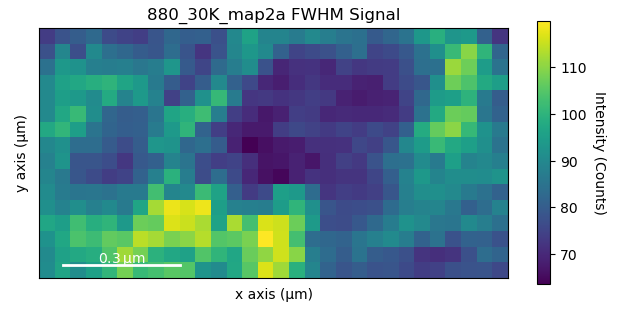

In [11]:
width = cl2.isig[600.:].estimate_peak_width()
width.plot(cmap='viridis')

**LumiSpy** provides an additional `centroid` function that determines the **centre of mass** of a peak.

*Note that, as with fitting, it might make more sense to run these routines in the energy domain after a Jacobian transformation than to convert the result.*

[########################################] | 100% Completed | 101.34 ms


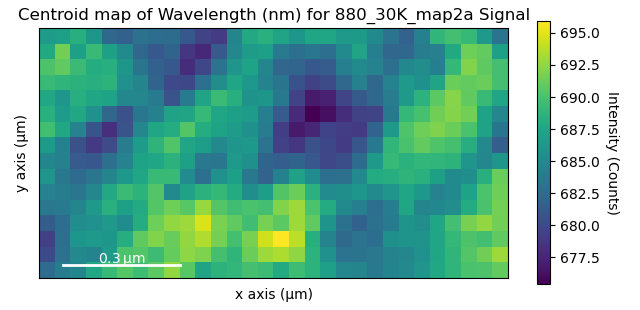

In [12]:
com = cl2.isig[600.:].centroid()
com.plot(cmap='viridis')

## Advanced fitting example

Finally, to showcase the power of fitting with a programming language, lets fit the more complicated dataset `cl3`:

1. Fit a spectrum with a skew normal component on a broad Gaussian as background.

2. Then add a variable number of sharp Gaussians depending on the number of peaks found by the peak finder routine.

*For reasons of calculation time, we run the fit on a single spectrum, but it could of course be looped across a complete spectral map - even with a variable number of peaks per spectrum.*

In [13]:
def getPeaks(S2):
    S2=S2.rebin(new_shape=[334])
    S2.smooth_savitzky_golay(window_length=15,polynomial_order=2)
    peaks = S2.find_peaks1D_ohaver(amp_thresh=0.2*np.max(S2.data),maxpeakn=10)[0]
    return peaks

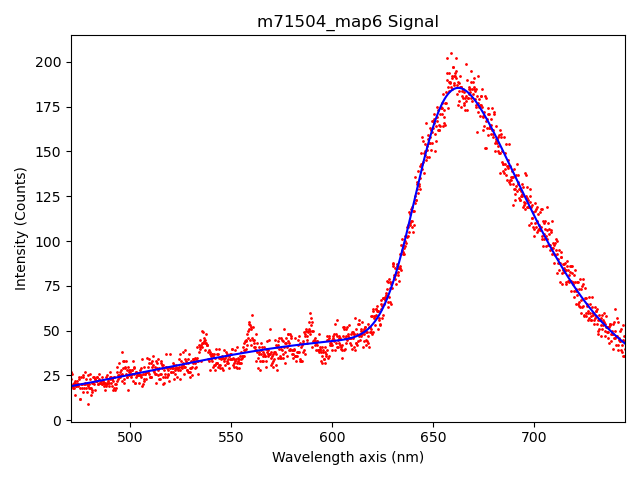

In [14]:
cl3 = cl3.inav[10,8]
m = cl3.create_model()
g1 = hs.model.components1D.SkewNormal()
g2 = hs.model.components1D.GaussianHF()
m.extend((g1,g2))
g1.x0.value=655
g1.scale.value=50
g1.shape.value=2
g1.A.value=220
g1.x0.bmin=635
g1.x0.bmax=675
g1.x0.bounded=True
g2.centre.value=580
g2.fwhm.value=180
g2.height.value=20
m.fit()
m.plot()

In [15]:
ng=10
S2 = cl3.deepcopy()
g = list()
for i in np.arange(ng):
    g.append(hs.model.components1D.GaussianHF())
m.extend(g)
for i in np.arange(ng):
    g[i].active_is_multidimensional = True
# The following code would need to be in a loop to run for a whole spectral image
# m.axes_manager.indices = cl3.axes_manager.indices
peaks = getPeaks(S2.inav[cl3.axes_manager.indices])
for i in np.arange(np.size(peaks)):
    g[i].centre.value=peaks['position'][i]
    g[i].centre.bmin=peaks['position'][i]-3
    g[i].centre.bmax=peaks['position'][i]+3
    g[i].centre.bounded=True
    g[i].fwhm.value=5
    g[i].fwhm.bmax=10
    g[i].fwhm.bmin=1
    g[i].fwhm.bounded=True
    g[i].height.value=20
    g[i].height.bmin=1
    g[i].height.bounded=True
if np.size(peaks)<ng:
    for i in np.arange(np.size(peaks),ng):
        g[i].active = False
m.fit(bounded=True)
m.plot()

NameError: name 'np' is not defined

## END
